testing how salmon performs given different fractions of mappings across transcripts
does it matter if a read is mapped to only one transcript out of 5 at the shared exon or no?

take hiv genome
build index of all transcriptomic n-mers (say 100bp reads): nmer: [transcriptomic position]
for every transcript - simulate reads at depth n
check which other transcripts it belongs to
output n mappings depending on experiment

In [1]:
import os
import re
import sys
import csv
import time
import scipy
import random
import requests
import subprocess
from pathlib import Path

import numpy as np
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt

from Bio import SeqIO

In [2]:
data_dir = Path.cwd().parent.parent.parent / 'HIV_Atlas_Creation' / 'data'

sequence_dir = data_dir / 'sequences'
assert sequence_dir.exists(), f"sequence_dir does not exist: {sequence_dir}"

annotation_dir = data_dir / 'annotation'
assert annotation_dir.exists(), f"annotation_dir does not exist: {annotation_dir}"

reference_fasta_fname = data_dir / 'reference' / 'K03455.1.fasta'
reference_gtf_fname = data_dir / 'reference' / 'K03455.1.gtf'

base_dir = Path.cwd().parent.parent

soft_dir = base_dir / 'soft'

outdir = base_dir / 'results/tests/salmon_multimappers'
outdir.mkdir(parents=True, exist_ok=True)

In [3]:
%load_ext autoreload
%autoreload 1

sys.path.insert(0, str(soft_dir / "genomic_scripts"))
%aimport definitions

In [4]:
read_len = 100
num_multi = [0,2,5,10,500]

salmon_idx_basename = outdir / 'K03454.salmon'

transcript_fasta_fname = outdir / 'K03455.1.transcripts.fasta'
reads_fname = outdir / 'reads.fasta'
read_data_fname = outdir / 'transcript_settings.tsv'
genomic_sam_fname = outdir / f"genomic.sam"
genomic_sorted_fname = outdir / f"genomic.bam"
transcriptomic_bam_fname = outdir / f"transcriptomic.bam"


# load chains of transcripts
transcript_chains = definitions.get_chains(reference_gtf_fname,"exon",True,as_dict=True)
# 'Env_Vpu.1': {'has_cds': 1,
#   'seqid': 'K03455.1',
#   'strand': '+',
#   'coords': 'K03455.1:455-9635',
#   'chain': ((455, 743), (5977, 9635))},

In [ ]:
# run gffread to extract transcript sequences
cmd = f"gffread -g {reference_fasta_fname} -w {transcript_fasta_fname} {reference_gtf_fname}"
print(cmd)
subprocess.run(cmd, shell=True)

gffread -g /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.fasta -w /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.gtf


CompletedProcess(args='gffread -g /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.fasta -w /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Creation/data/reference/K03455.1.gtf', returncode=0)

In [7]:
# build salmon index
cmd = f"salmon index -t {transcript_fasta_fname} -i {salmon_idx_basename} -k 31"
print(cmd)
subprocess.run(cmd, shell=True)

salmon index -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -i /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon -k 31


Version Server Response: Not Found
index ["/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon"] did not previously exist  . . . creating it
[2024-12-23 17:11:33.557] [jLog] [warning] The salmon index is being built without any decoy sequences.  It is recommended that decoy sequence (either computed auxiliary decoy sequence or the genome of the organism) be provided during indexing. Further details can be found at https://salmon.readthedocs.io/en/latest/salmon.html#preparing-transcriptome-indices-mapping-based-mode.
[2024-12-23 17:11:33.557] [jLog] [info] building index
out : /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon
[2024-12-23 17:11:33.577] [puff::index::jointLog] [info] Running fixFasta

[Step 1 of 4] : counting k-mers

[2024-12-23 17:11:33.586] [puff::index::jointLog] [warning] Removed 1 transcripts that were sequence duplicates of indexed transcripts.
[2024-12-23 17:11:33.

Threads = 2
Vertex length = 31
Hash functions = 5
Filter size = 1048576
Capacity = 2
Files: 
/ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon/ref_k31_fixed.fa
--------------------------------------------------------------------------------
Round 0, 0:1048576
Pass	Filling	Filtering
1	0	1	
2	0	0
True junctions count = 32
False junctions count = 0
Hash table size = 32
Candidate marks count = 765
--------------------------------------------------------------------------------
Reallocating bifurcations time: 0
True marks count: 765
Edges construction time: 0
--------------------------------------------------------------------------------
Distinct junctions = 32



TwoPaCo::buildGraphMain:: allocated with scalable_malloc; freeing.
TwoPaCo::buildGraphMain:: Calling scalable_allocation_command(TBBMALLOC_CLEAN_ALL_BUFFERS, 0);
allowedIn: 10
Max Junction ID: 32
seen.size():265 kmerInfo.size():33
approximateContigTotalLength: 4574
counters for complex kmers:
(prec>1 & succ>1)=0 | (succ>1 & isStart)=0 | (prec>1 & isEnd)=0 | (isStart & isEnd)=0
contig count: 53 element count: 11195 complex nodes: 0
# of ones in rank vector: 52
[2024-12-23 17:11:34.831] [puff::index::jointLog] [info] Starting the Pufferfish indexing by reading the GFA binary file.
[2024-12-23 17:11:34.831] [puff::index::jointLog] [info] Setting the index/BinaryGfa directory /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon
size = 11195
-----------------------------------------
| Loading contigs | Time = 478.01 us
-----------------------------------------
size = 11195
-----------------------------------------
| Loading contig boundaries 

for info, total work write each  : 2.331    total work inram from level 3 : 4.322  total work raw : 25.000 
Bitarray           56512  bits (100.00 %)   (array + ranks )
final hash             0  bits (0.00 %) (nb in final hash 0)


[2024-12-23 17:11:36.631] [jLog] [info] done building index


CompletedProcess(args='salmon index -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -i /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon -k 31', returncode=0)

In [6]:
# build index of nmers in the transcripts

read_positions = dict()
for record in SeqIO.parse(transcript_fasta_fname, 'fasta'):
    seq = str(record.seq)
    for i in range(len(seq) - read_len + 1):
        read = seq[i:i+read_len]
        if read not in read_positions:
            read_positions[read] = []
        # add the transcript id and the position of the read in the transcript
        read_positions[read].append((record.id, i))

In [5]:
# simulate target TPM for the transcripts
transcript_read_data = dict()
for record in SeqIO.parse(transcript_fasta_fname, 'fasta'):
    transcript_read_data[record.id] = dict()
    transcript_read_data[record.id]["depth"] = random.randint(1, 10)
    transcript_read_data[record.id]["len"] = len(record.seq)
    
# write out the simulated transcript settings to a tsv file
with open(read_data_fname, 'w') as outFP:
    outFP.write('transcript_id\tdepth\tlen\n')
    for transcript_id, data in transcript_read_data.items():
        outFP.write(f"{transcript_id}\t{data['depth']}\t{data['len']}\n")

In [6]:
# now we need to simulate reads and transcriptomic alignments

# simulate reads
with open(reads_fname, 'w') as outFP:
    for record in SeqIO.parse(transcript_fasta_fname, 'fasta'):
        depth = transcript_read_data[record.id]["depth"]
        seq = str(record.seq)
        for i in range(len(seq) - read_len + 1):
            read = seq[i:i+read_len]
            for d in range(depth):
                outFP.write(f">{record.id}_{i+1}_{d}\n{read}\n")

In [20]:
# we now need to produce genomic alignments for the data so that we can run mudskipper and ocmpare results

# iterate over the reads and convert position on the transcript to genomic position
with open(genomic_sam_fname, 'w') as outFP:
    # build the header
    outFP.write(f"@HD\tVN:1.0\tSO:unsorted\n")
    # get list of genomic seqids from the reference_fasta_fname
    for record in SeqIO.parse(reference_fasta_fname, 'fasta'):
        outFP.write(f"@SQ\tSN:{record.id}\tLN:{len(record.seq)}\n")

    for record in SeqIO.parse(reads_fname, 'fasta'):
        read_id = record.id
        read = str(record.seq)
        tid, pos = read_id.rsplit('_',2)[:2]
        pos = int(pos)-1
        
        # get the chain for the transcript
        chain = transcript_chains[tid]['chain']
        strand = transcript_chains[tid]['strand']
        seqid = transcript_chains[tid]['seqid']

        # get the genomic position
        genomic_start = definitions.trans2genome(chain, strand, pos)
        genomic_end = definitions.trans2genome(chain, strand, pos + read_len - 1)
        genomic_chain = definitions.cut(chain, genomic_start, genomic_end)

        # build cigar string from chain
        cigar = definitions.chain2cigar(genomic_chain)

        # write out the read
        outFP.write(f"{read_id}\t0\t{seqid}\t{genomic_start}\t255\t{cigar}\t*\t0\t0\t{read}\t*\n")

# sort the sam file
cmd = f"samtools sort -o {genomic_sorted_fname} {genomic_sam_fname}"
print(cmd)
subprocess.run(cmd, shell=True, check=True)

samtools sort -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/genomic.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/genomic.sam


CompletedProcess(args='samtools sort -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/genomic.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/genomic.sam', returncode=0)

In [9]:
# run salmon on the reads themselves
cmd = f"salmon quant -i {salmon_idx_basename} -l A -r {reads_fname} -o {outdir}/salmon_reads --validateMappings"
print(cmd)
subprocess.run(cmd, shell=True)

salmon quant -i /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon -l A -r /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads.fasta -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_reads --validateMappings


Version Server Response: Not Found
### salmon (selective-alignment-based) v1.10.3
### [ program ] => salmon 
### [ command ] => quant 
### [ index ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon }
### [ libType ] => { A }
### [ unmatedReads ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads.fasta }
### [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_reads }
### [ validateMappings ] => { }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_reads/logs
[2024-12-23 17:15:53.590] [jointLog] [info] setting maxHashResizeThreads to 128
[2024-12-23 17:15:53.590] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 17:15:53.590] [jointLog] [info] Usage of --validateMappings implies use of minS

CompletedProcess(args='salmon quant -i /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03454.salmon -l A -r /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads.fasta -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_reads --validateMappings', returncode=0)

In [7]:
# now for each read we need to produce a SAM record including multimappers for each fraction. if 0 - only the primary alignment is included
for nm in num_multi:
    # first write the header
    sam_fname = outdir / f"reads_{nm}.sam"
    sam_genomic_fname = outdir / f"reads_{nm}_genomic.sam"
    with open(sam_fname, 'w') as outFP, open(sam_genomic_fname, 'w') as outFP_genomic:
        outFP.write(f"@HD\tVN:1.0\tSO:unsorted\n")
        outFP_genomic.write(f"@HD\tVN:1.0\tSO:unsorted\n")
        for record in SeqIO.parse(transcript_fasta_fname, 'fasta'):
            outFP.write(f"@SQ\tSN:{record.id}\tLN:{len(record.seq)}\n")
        for record in SeqIO.parse(reference_fasta_fname, 'fasta'):
            outFP_genomic.write(f"@SQ\tSN:{record.id}\tLN:{len(record.seq)}\n")
        
        # now write the reads
        for record in SeqIO.parse(reads_fname, 'fasta'):
            read_id = record.id
            read = str(record.seq)
            tid, pos = read_id.rsplit('_',2)[:2]
            # convert to 0-based
            pos = int(pos)-1
            # get the multimappers
            multimappers = read_positions[read]
            random.shuffle(multimappers)
            multimappers = multimappers[:nm]

            # pick primary alignment
            primary = multimappers[0] if len(multimappers) > 0 else (tid, pos)
            outFP.write(f"{read_id}\t0\t{primary[0]}\t{primary[1]+1}\t255\t{read_len}M\t*\t0\t0\t{read}\t*\n")
            # write out the genomic alignment
            chain = transcript_chains[tid]['chain']
            strand = transcript_chains[tid]['strand']
            seqid = transcript_chains[tid]['seqid']
            genomic_start = definitions.trans2genome(chain, strand, pos)
            genomic_end = definitions.trans2genome(chain, strand, pos + read_len - 1)
            genomic_chain = definitions.cut(chain, genomic_start, genomic_end)
            cigar = definitions.chain2cigar(genomic_chain)
            outFP_genomic.write(f"{read_id}\t0\t{seqid}\t{genomic_start}\t255\t{cigar}\t*\t0\t0\t{read}\t*\n")
            for i, (tid, pos) in enumerate(multimappers[1:]):
                outFP.write(f"{read_id}\t256\t{tid}\t{pos+1}\t255\t{read_len}M\t*\t0\t0\t{read}\t*\n")
                # write out the genomic alignment
                chain = transcript_chains[tid]['chain']
                strand = transcript_chains[tid]['strand']
                seqid = transcript_chains[tid]['seqid']
                genomic_start = definitions.trans2genome(chain, strand, pos)
                genomic_end = definitions.trans2genome(chain, strand, pos + read_len - 1)
                genomic_chain = definitions.cut(chain, genomic_start, genomic_end)
                cigar = definitions.chain2cigar(genomic_chain)
                outFP_genomic.write(f"{read_id}\t256\t{seqid}\t{genomic_start}\t255\t{cigar}\t*\t0\t0\t{read}\t*\n")
    
    bam_fname = outdir / f"reads_{nm}.bam"
    cmd = f"samtools sort -n -o {bam_fname} {sam_fname}"
    print(cmd)
    subprocess.run(cmd, shell=True, check=True)

samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0.sam
samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_2.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_2.sam
samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_5.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_5.sam
samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_10.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_10.sam


[bam_sort_core] merging from 1 files and 1 in-memory blocks...


samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_500.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_500.sam


[bam_sort_core] merging from 5 files and 1 in-memory blocks...


In [8]:
# now we need to run salmon on these alignments to test effect of including multimappers

for nm in num_multi:
    cmd = f"salmon quant -l SF -t {transcript_fasta_fname} -a {outdir}/reads_{nm}.bam -o {outdir}/salmon_output_{nm}"
    print(cmd)
    subprocess.run(cmd, shell=True)

salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0 }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0/logs
[2024-12-23 18:45:21.638] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2024-12-23 18:45:21.638] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 18:45:21.638] [jointLog] [info] num

salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_2.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_2


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_2.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_2 }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_2/logs
[2024-12-23 18:45:28.943] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2024-12-23 18:45:28.943] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 18:45:28.943] [jointLog] [info] num

salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_5.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_5


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_5.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_5 }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_5/logs
[2024-12-23 18:45:37.243] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2024-12-23 18:45:37.243] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 18:45:37.243] [jointLog] [info] num

salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_10.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_10


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_10.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_10 }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_10/logs
[2024-12-23 18:45:53.069] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2024-12-23 18:45:53.069] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 18:45:53.070] [jointLog] [info] 

salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_500.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_500


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_500.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_500 }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_500/logs
[2024-12-23 18:46:21.457] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2024-12-23 18:46:21.457] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2024-12-23 18:46:21.458] [jointLog] [inf

In [30]:
g2t_bin = soft_dir / 'g2t'
os.environ['PYTHONPATH'] = str(g2t_bin) + ":" + os.environ.get('PYTHONPATH', '')
cmd = [sys.executable, '-m', 'g2t',
 "--alignment", outdir / f"reads_0_genomic.sam",
 "--annotation", reference_gtf_fname,
 "--output" ,outdir / f"reads_0_g2t.bam"]
result = subprocess.run(
    cmd,
    cwd=g2t_bin
)

In [32]:
cmd = f"samtools sort -n -o {outdir}/reads_0_g2t.nsort.bam {outdir}/reads_0_g2t.bam"
print(cmd)
subprocess.run(cmd, shell=True, check=True)
# run salmon on the g2t output
cmd = f"salmon quant -l SF -t {transcript_fasta_fname} -a {outdir}/reads_0_g2t.nsort.bam -o {outdir}/salmon_output_0_g2t"
print(cmd)
subprocess.run(cmd, shell=True)

samtools sort -n -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0_g2t.nsort.bam /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0_g2t.bam


[bam_sort_core] merging from 5 files and 1 in-memory blocks...


salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0_g2t.nsort.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0_g2t


Version Server Response: Not Found
# salmon (alignment-based) v1.10.3
# [ program ] => salmon 
# [ command ] => quant 
# [ libType ] => { SF }
# [ targets ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta }
# [ alignments ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0_g2t.nsort.bam }
# [ output ] => { /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0_g2t }
Logs will be written to /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0_g2t/logs
[2025-01-11 22:42:09.733] [jointLog] [info] setting maxHashResizeThreads to 8
Library format { type:single end, relative orientation:none, strandedness:sense }
[2025-01-11 22:42:09.733] [jointLog] [info] Fragment incompatibility prior below threshold.  Incompatible fragments will be ignored.
[2025-01-11 22:42:09.734] [jo

CompletedProcess(args='salmon quant -l SF -t /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/K03455.1.transcripts.fasta -a /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/reads_0_g2t.nsort.bam -o /ccb/salz8-3/avaraby1/HIV_Atlas/HIV_Atlas_Experiments/results/tests/salmon_multimappers/salmon_output_0_g2t', returncode=0)

In [6]:
# now we should load results into a pandas dataframe and plot the rsults comparing againt the simulated depth

# load the simulated data
rdf = pd.read_csv(read_data_fname, sep='\t')

# get effective length from the first salmon run
salmon_fname = outdir / f"salmon_output_{num_multi[0]}" / "quant.sf"
sdf = pd.read_csv(salmon_fname, sep='\t')
rdf = rdf.merge(sdf[['Name','EffectiveLength']], left_on='transcript_id', right_on='Name', how='left')

# compute number of simulated reads from depth and length and read_len
rdf['num_reads'] = (rdf['depth'] * rdf['EffectiveLength']) - ((read_len-1) * rdf['depth'])
# compute expected tpm
rdf['norm_reads'] = rdf['num_reads'] / rdf['EffectiveLength']
rdf['tpm'] = (rdf['norm_reads'] / rdf['norm_reads'].sum()) * 1e6

# add salmon results with raw reads
salmon_fname = outdir / "salmon_reads" / "quant.sf"
sdf = pd.read_csv(salmon_fname, sep='\t')
sdf.columns = [f"{c}_reads" if c != 'Name' else "transcript_id" for c in sdf.columns]
rdf = rdf.merge(sdf[["transcript_id","TPM_reads","NumReads_reads"]], on='transcript_id', how='left')

# add each salmon result to the dataframe
for nm in num_multi:
    salmon_fname = outdir / f"salmon_output_{nm}" / "quant.sf"
    sdf = pd.read_csv(salmon_fname, sep='\t')
    sdf.columns = [f"{c}_{nm}" if c != 'Name' else "transcript_id" for c in sdf.columns]
    rdf = rdf.merge(sdf[["transcript_id",f"TPM_{nm}",f"NumReads_{nm}"]], on='transcript_id', how='left')

# add salmon with g2t
salmon_fname = outdir / "salmon_output_0_g2t" / "quant.sf"
sdf = pd.read_csv(salmon_fname, sep='\t')
sdf.columns = [f"{c}_g2t" if c != 'Name' else "transcript_id" for c in sdf.columns]
rdf = rdf.merge(sdf[["transcript_id","TPM_g2t","NumReads_g2t"]], on='transcript_id', how='left')

rdf

,transcript_id,depth,len,Name,EffectiveLength,num_reads,norm_reads,tpm,TPM_reads,NumReads_reads,...,TPM_2,NumReads_2,TPM_5,NumReads_5,TPM_10,NumReads_10,TPM_500,NumReads_500,TPM_g2t,NumReads_g2t
0,Env_Vpu.1,3,3948,Env_Vpu.1,3698.0,10797.0,2.919686,13791.130112,14955.187592,13513.952,...,21456.580207,18984.035,19779.064216,17646.938,19125.835849,17161.125,15025.554158,13577.146,14877.962048,13442.406
1,Env_Vpu.10,6,4038,Env_Vpu.10,3788.0,22134.0,5.843189,27600.286904,21861.980325,20235.926,...,21696.226166,19663.249,21493.922243,19643.658,21205.587995,19490.308,21962.297266,20328.196,21930.772942,20296.940
2,Env_Vpu.11,2,4044,Env_Vpu.11,3794.0,7390.0,1.947812,9200.486091,19795.753279,18352.404,...,21809.941758,19797.618,21275.925465,19475.226,19435.011630,17891.245,19842.839504,18395.527,19459.253606,18038.074
3,Env_Vpu.12,2,4062,Env_Vpu.12,3812.0,7426.0,1.948059,9201.650087,19996.341555,18626.320,...,21763.641905,19849.317,20661.923247,19002.921,19996.079810,18495.078,20010.588404,18639.053,20014.456118,18640.748
4,Env_Vpu.13,8,4072,Env_Vpu.13,3822.0,29784.0,7.792779,36809.168052,24335.887220,22728.014,...,21935.505367,20058.546,21072.995062,19431.829,22132.647829,20524.968,24481.208123,22863.074,24627.304344,22997.160
5,Env_Vpu.14,5,4088,Env_Vpu.14,3838.0,18695.0,4.871027,23008.280344,20680.792854,19395.267,...,21867.651743,20080.209,20520.728234,19001.788,20045.142082,18666.914,20711.514642,19423.519,20855.107561,19556.181
6,Env_Vpu.15,6,4094,Env_Vpu.15,3844.0,22470.0,5.845473,27611.077484,19191.255495,18026.457,...,21910.326824,20150.849,20657.777171,19158.597,20350.054017,18980.488,19186.286589,18021.270,19075.767882,17915.629
7,Env_Vpu.16,8,4112,Env_Vpu.16,3862.0,30104.0,7.794925,36819.305902,18089.134009,17070.792,...,21878.959153,20216.224,20820.693993,19400.110,19075.185996,17874.729,18037.715767,17021.777,18265.157199,17234.645
8,Env_Vpu.2,5,3964,Env_Vpu.2,3714.0,18075.0,4.866721,22987.940684,20033.709949,18181.382,...,21591.489250,19186.052,19743.939852,17691.817,20781.931912,18727.777,20093.286704,18234.925,19964.875493,18116.536
9,Env_Vpu.3,6,3970,Env_Vpu.3,3720.0,21726.0,5.840323,27586.747296,24657.201255,22413.534,...,22312.629544,19858.883,21910.425984,19664.843,22533.406491,20338.935,24658.545429,22414.109,24534.786771,22299.333


/tmp/ipykernel_275627/3569440583.py:86: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


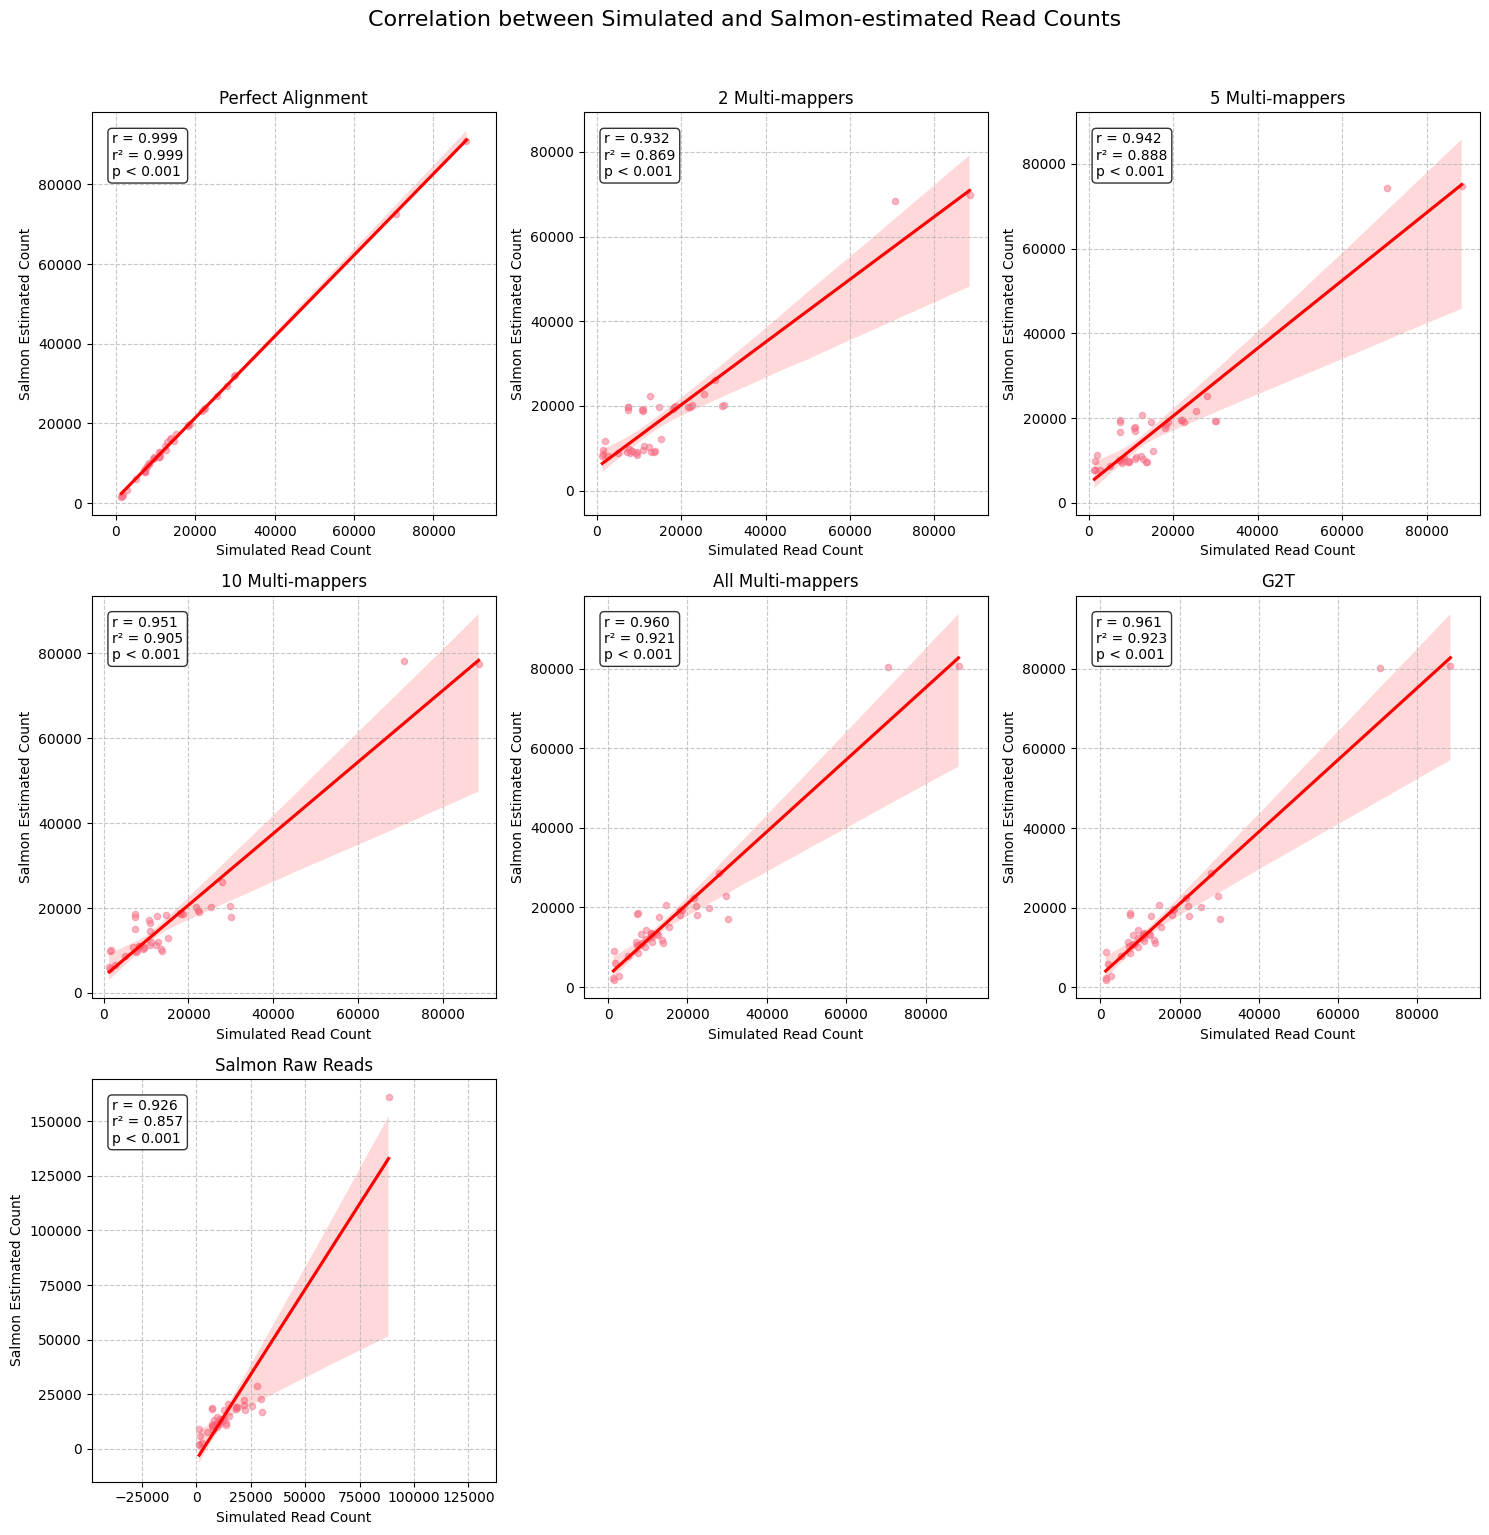

In [7]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_palette("husl")

# Define comparisons
comparisons = {
    "Perfect Alignment": "NumReads_0",
    "2 Multi-mappers": "NumReads_2",
    "5 Multi-mappers": "NumReads_5",
    "10 Multi-mappers": "NumReads_10",
    "All Multi-mappers": "NumReads_500",
    "G2T": "NumReads_g2t",
    "Salmon Raw Reads": "NumReads_reads"
}

# Calculate optimal grid dimensions
n_plots = len(comparisons)
n_cols = 3  # You can adjust this
n_rows = int(np.ceil(n_plots / n_cols))

# Create figure with fixed subplot dimensions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
fig.suptitle('Correlation between Simulated and Salmon-estimated Read Counts', 
             fontsize=16, y=1.02)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Function to add correlation statistics
def add_correlation_stats(x, y, ax):
    # Filter out NaN or infinite values
    valid_idx = np.isfinite(x) & np.isfinite(y)
    x_valid, y_valid = x[valid_idx], y[valid_idx]
    
    if len(x_valid) > 1 and len(y_valid) > 1:
        # Calculate correlation and p-value
        corr, p_value = stats.pearsonr(x_valid, y_valid)
        r_squared = corr ** 2
        # Add stats text
        stats_text = f'r = {corr:.3f}\nr² = {r_squared:.3f}'
        if p_value < 0.001:
            stats_text += '\np < 0.001'
        else:
            stats_text += f'\np = {p_value:.3f}'
    else:
        stats_text = 'Insufficient data'
    
    ax.text(0.05, 0.95, stats_text,
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Plot each comparison
for i, (title, col) in enumerate(comparisons.items()):
    ax = axes[i]  # Get subplot axis
    if col in rdf.columns:
        # Filter valid data for plotting
        data = rdf[['num_reads', col]].dropna().replace([np.inf, -np.inf], np.nan).dropna()
        if not data.empty:
            # Create scatter plot
            sns.regplot(x='num_reads', y=col, data=data, ax=ax,
                        scatter_kws={'alpha': 0.5, 's': 20},
                        line_kws={'color': 'red'})
            # Add correlation statistics
            add_correlation_stats(data['num_reads'], data[col], ax)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center')
    else:
        ax.text(0.5, 0.5, 'Column missing', ha='center', va='center')
    
    # Customize axes
    ax.set_xlabel('Simulated Read Count')
    ax.set_ylabel('Salmon Estimated Count')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True, linestyle='--', alpha=0.7)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure (optional)
plt.savefig('correlation_plots.png', dpi=300, bbox_inches='tight')
plt.show()


/tmp/ipykernel_275627/3792351605.py:62: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


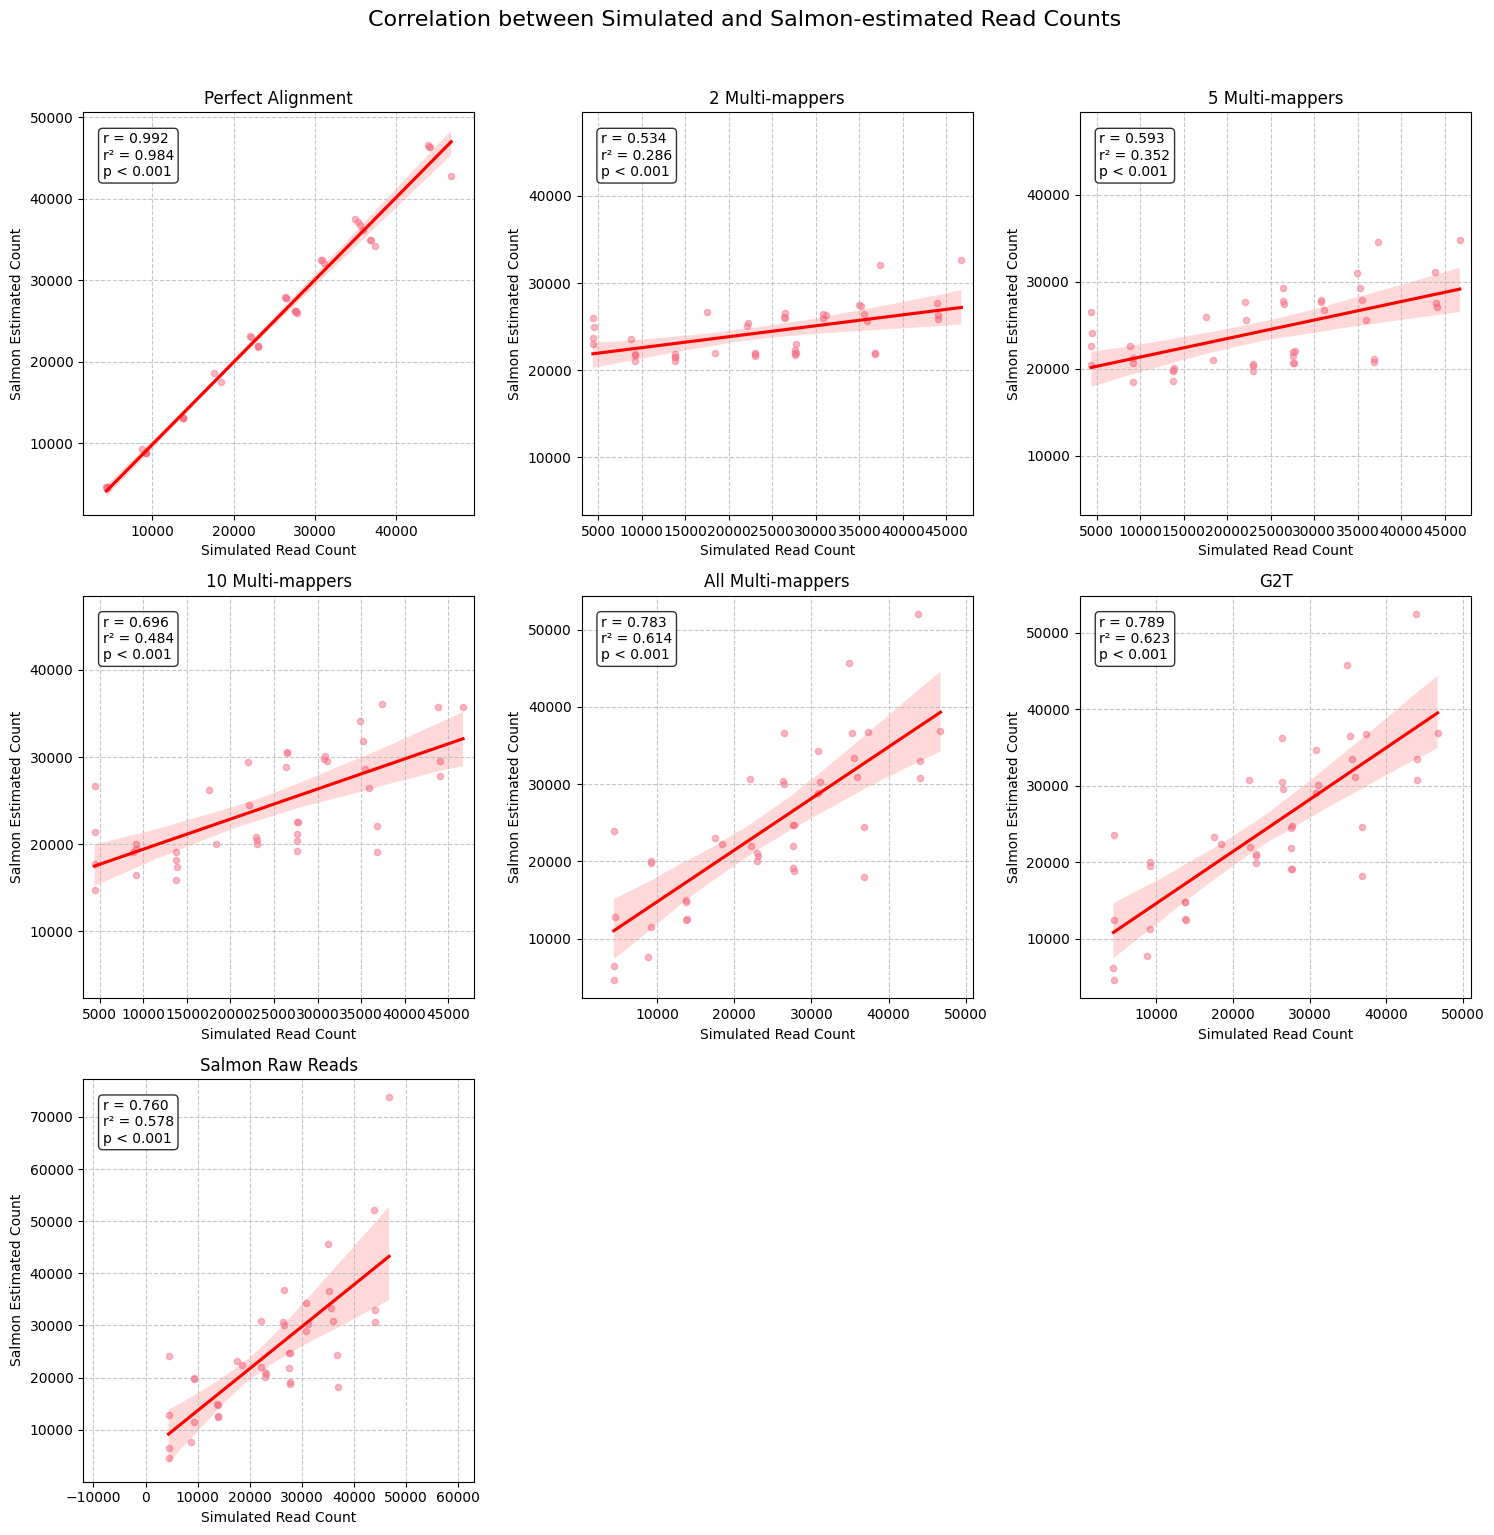

In [10]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_palette("husl")

# Define comparisons
comparisons = {
    "Perfect Alignment": "TPM_0",
    "2 Multi-mappers": "TPM_2",
    "5 Multi-mappers": "TPM_5",
    "10 Multi-mappers": "TPM_10",
    "All Multi-mappers": "TPM_500",
    "G2T": "TPM_g2t",
    "Salmon Raw Reads": "TPM_reads"
}

# Calculate optimal grid dimensions
n_plots = len(comparisons)
n_cols = 3  # You can adjust this
n_rows = int(np.ceil(n_plots / n_cols))

# Create figure with fixed subplot dimensions
fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows), constrained_layout=True)
fig.suptitle('Correlation between Simulated and Salmon-estimated Read Counts', 
             fontsize=16, y=1.02)

# Flatten axes array for easy indexing
axes = axes.flatten()

# Plot each comparison
for i, (title, col) in enumerate(comparisons.items()):
    ax = axes[i]  # Get subplot axis
    if col in rdf.columns:
        # Filter valid data for plotting
        data = rdf[['tpm', col]].dropna().replace([np.inf, -np.inf], np.nan).dropna()
        if not data.empty:
            # Create scatter plot
            sns.regplot(x='tpm', y=col, data=data, ax=ax,
                        scatter_kws={'alpha': 0.5, 's': 20},
                        line_kws={'color': 'red'})
            # Add correlation statistics
            add_correlation_stats(data['tpm'], data[col], ax)
        else:
            ax.text(0.5, 0.5, 'No valid data', ha='center', va='center')
    else:
        ax.text(0.5, 0.5, 'Column missing', ha='center', va='center')
    
    # Customize axes
    ax.set_xlabel('Simulated Read Count')
    ax.set_ylabel('Salmon Estimated Count')
    ax.set_title(title)
    ax.set_aspect('equal', adjustable='datalim')
    ax.grid(True, linestyle='--', alpha=0.7)

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Adjust layout for better spacing
plt.tight_layout()

# Save the figure (optional)
plt.savefig('correlation_plots.png', dpi=300, bbox_inches='tight')
plt.show()